In [2]:
%matplotlib inline
import numpy as np
import poppy
import matplotlib.pyplot as plt
import astropy.units as u
from llowfs import VortexMask

In [3]:
import logging
logging.getLogger('poppy').setLevel(logging.WARN)  

The total intensity in the output PSF is only 0.010 of the input.


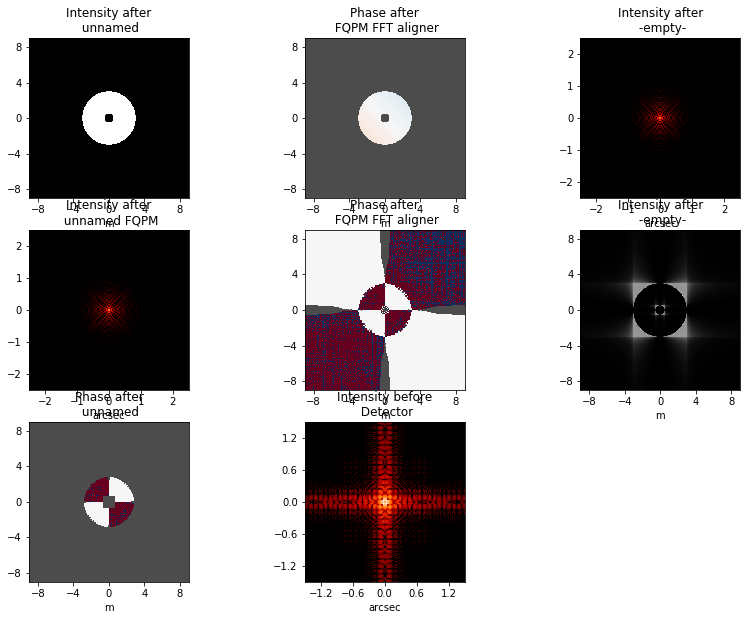

In [10]:
oversample=4
pixelscale = 0.010  #arcsec/pixel
wavelength = 632e-9*u.m

osys = poppy.OpticalSystem("test", oversample=oversample,pupil_diameter=18*u.m)
ap = poppy.CircularAperture(radius=3.0*u.m)
obsc = poppy.SecondaryObscuration(secondary_radius=0.5*u.m, n_supports=0)
osys.add_pupil(poppy.CompoundAnalyticOptic(opticslist=[ap,obsc]))
osys.add_pupil(poppy.FQPM_FFT_aligner())
osys.add_image()
fqpm = poppy.IdealFQPM(wavelength=wavelength)
fqpm._wavefront_display_hint='phase'
osys.add_image(fqpm)
osys.add_pupil(poppy.FQPM_FFT_aligner(direction='backward'))
osys.add_pupil()
lyot_stop = poppy.CircularAperture(radius=2.8*u.m,name='Lyot Stop')
lyot_obsc = poppy.InverseTransmission(poppy.SquareAperture(size=1.4*u.m))
lyot = poppy.CompoundAnalyticOptic(opticslist=[lyot_stop,lyot_obsc])

lyot._wavefront_display_hint='intensity' # advanced tweak: ensure intensity rather than phase gets displayed
osys.add_pupil(lyot)
osys.add_detector(pixelscale=pixelscale, fov_arcsec=3.0)

plt.figure(figsize=(14,10))
corpsf = osys.calc_psf(wavelength=wavelength, display_intermediates=True)

print("The total intensity in the output PSF is only {0:.3f} of the input.".format(corpsf[0].data.sum()))

PlaneType.pupil


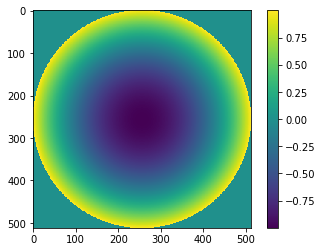

In [6]:
sensor_defocus = 2 #waves peak-to-valley
wf = poppy.Wavefront(diam=10*u.m,wavelength=632e-9,npix=512,oversample=2,pixelscale=None)
print(wf.planetype)
#Calc of peak-to-valley WFE: https://poppy-optics.readthedocs.io/en/stable/wfe.html
defocus_coeff = 1/2/np.sqrt(3)*sensor_defocus*wavelength.to(u.m).value
zke = poppy.ZernikeWFE(radius=5*u.m,coefficients=[0,0,0,defocus_coeff])
opd = zke.get_opd(wf)
plt.figure()
plt.imshow(opd/632e-9)
plt.colorbar()

PlaneType.image


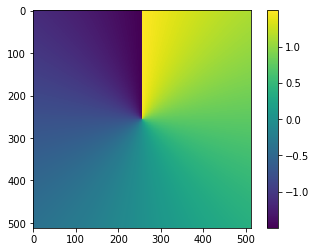

In [7]:
wf = poppy.Wavefront(diam=0.5*u.m,wavelength=632e-9,npix=512,oversample=4,pixelscale=0.01)
print(wf.planetype)
vtx = VortexMask(charge=3,wavelength=632e-9*u.m)
opd = vtx.get_opd(wf)

plt.figure()
plt.imshow(opd/632e-9)
plt.colorbar()

In [7]:
def generate_coefficients(wfe_budget):
    coefficients = []
    for term in wfe_budget:
        coefficients.append(
            # convert nm to meters, get value in range
            np.random.uniform(low=-1e-9 * term, high=1e-9 * term)
        )
    return coefficients

The total intensity in the output PSF is only 0.000000 of the input.


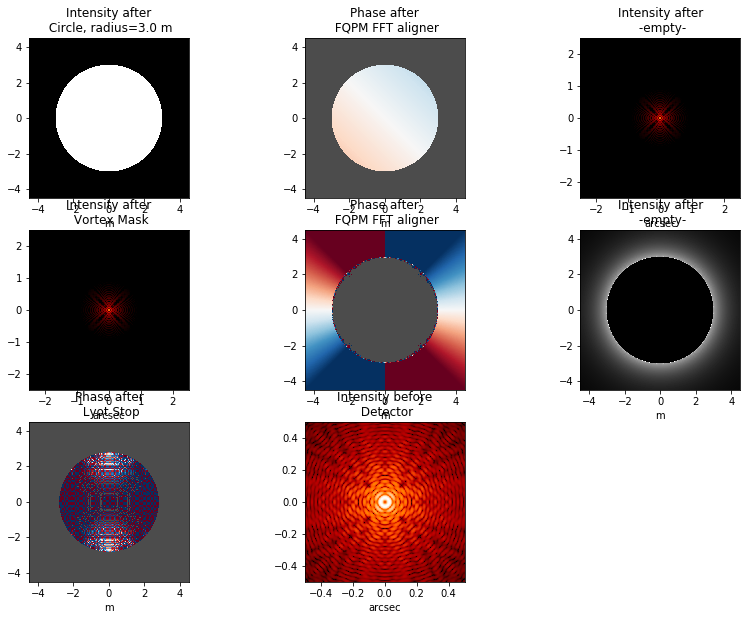

In [12]:
oversample=4
pixelscale = 0.010  #arcsec/pixel
wavelength = 632e-9*u.m
pupil_radius = 3.0
sensor_defocus = 2*wavelength.to(u.m).value
wfe = [0, 25, 25, 25, 25, 25]

osys = poppy.OpticalSystem("test", oversample=oversample)
osys.add_pupil(poppy.CircularAperture(radius=pupil_radius,pad_factor=1.5))
#error = poppy.ZernikeWFE(radius=pupil_radius, coefficients=generate_coefficients(wfe))
#osys.add_pupil(error)
osys.add_pupil(poppy.FQPM_FFT_aligner())
osys.add_image()
vtx = VortexMask(charge=2,wavelength=wavelength,name='Vortex Mask')
osys.add_image(vtx)
osys.add_pupil(poppy.FQPM_FFT_aligner(direction='backward'))
osys.add_pupil()
#lyot = poppy.InverseTransmission(poppy.CircularAperture(radius=3.0,name='Lyot Stop'))
lyot = poppy.CircularAperture(radius=2.8,name='Lyot Stop')
lyot._wavefront_display_hint='intensity' # advanced tweak: ensure intensity rather than phase gets displayed
osys.add_pupil(lyot)
osys.add_detector(pixelscale=pixelscale, fov_arcsec=1.0)
defocus = poppy.ZernikeWFE(radius=pupil_radius, coefficients=[0,0,0,sensor_defocus])
plt.figure(figsize=(14,10))
corpsf = osys.calc_psf(wavelength=wavelength, display_intermediates=True)


print("The total intensity in the output PSF is only {0:.6f} of the input.".format(corpsf[0].data.sum()))

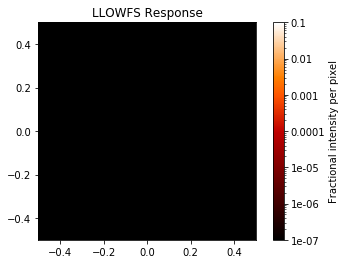

In [11]:
plt.figure()
poppy.display_psf(corpsf,title='LLOWFS Response')